ASSIGNMENT 2 -
Name : Chairani Tiara Sayyu
Matrix Name : P104718

In [ ]:
import sys
import nltk

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


READ DATA

In [ ]:
df = pd.read_csv('dataset.csv')
df = df[['text','humor']]
df = df[pd.notnull(df['text'])]
df.rename(columns = {'text':'text'}, inplace = True)
df.head(10)

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False
5,"Martha stewart tweets hideous food photo, twit...",False
6,What is a pokemon master's favorite kind of pa...,True
7,Why do native americans hate it when it rains ...,True
8,"Obama's climate change legacy is impressive, i...",False
9,"My family tree is a cactus, we're all pricks.",True


In [ ]:
df.shape

(200000, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    200000 non-null  object
 1   humor   200000 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 3.2+ MB


In [ ]:
df.index = range(200000)
df['text'].apply(lambda x: len(x.split(' '))).sum()

2398856

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


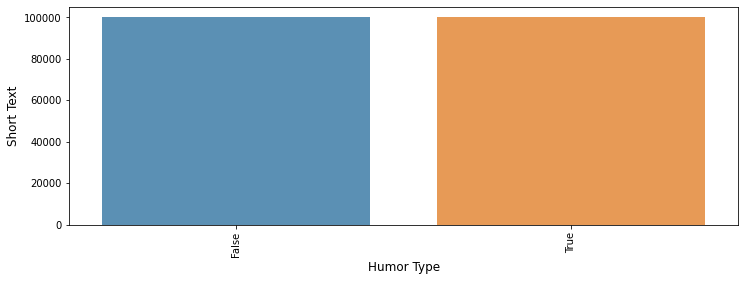

In [ ]:
cnt_pro = df['humor'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Short Text', fontsize=12)

plt.xlabel('Humor Type', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [ ]:
def print_requirementFeedback(index):
    #example = df[df.index == index][['text', 'humor']].values[0]
    example = df[df.index == index][['text', 'humor']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Humor Type:', example[1])
print_requirementFeedback(12)

Want to know why athletes chose to #takeaknee? look at our broken justice system
Humor Type: False


DATA PRE-PROCESSING

In [ ]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['text'] = df['text'].apply(cleanText)

In [ ]:
df.head()

,text,humor
0,"joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,watch: darvish gave hitter whiplash with slow ...,False
2,what do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"pasco police shot meican migrant from behind, ...",False


In [ ]:
df['text'].head()

0    joe biden rules out 2020 bid: 'guys, i'm not r...
1    watch: darvish gave hitter whiplash with slow ...
2    what do you call a turtle without its shell? d...
3        5 reasons the 2016 election feels so personal
4    pasco police shot meican migrant from behind, ...
Name: text, dtype: object

In [ ]:
nltk.download('punkt')
import nltk
from nltk.corpus import stopwords

train, test = train_test_split(df, test_size=0.2, random_state=42)

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.humor]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.humor]), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


FEATURE EXTRACTION

In [ ]:
import pandas as pd
import numpy as np


from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression

import re
import seaborn as sns
import matplotlib.pyplot as plt

FEATURE - DOC2VEC

In [ ]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 160000/160000 [00:00<00:00, 2268248.85it/s]


In [ ]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 160000/160000 [00:00<00:00, 2674416.43it/s]


CPU times: user 8min 52s, sys: 50.5 s, total: 9min 43s
Wall time: 5min 45s


In [ ]:
#Building the Final Vector Feature for the Classifier
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

#dataset
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

#Train the Logistic Regression Classifier.
logreg = LogisticRegression(solver='lbfgs', max_iter=400)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy LR %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score LR (DOC2VEC): {}'.format(f1_score(y_test, y_pred, average='macro')))
print('Testing Precision score LR (DOC2VEC): {}'.format(precision_score(y_test, y_pred, average='macro')))
print('Testing Recall score LR(DOC2VEC): {}'.format(recall_score(y_test, y_pred, average='macro')))

Testing accuracy LR 0.647375
Testing F1 score LR (DOC2VEC): 0.6473644295283778
Testing Precision score LR (DOC2VEC): 0.647392239171936
Testing Recall score LR(DOC2VEC): 0.6473747278684368


In [ ]:
#NB classifier
from sklearn.naive_bayes import GaussianNB
cNB = GaussianNB()
cNB.fit(X_train, y_train) 
y_pred_NB = cNB.predict(X_test)
print('Testing accuracy NB %s' % accuracy_score(y_test, y_pred_NB))
print('Testing F1 score NB (DOC2VEC): {}'.format(f1_score(y_test, y_pred_NB, average='macro')))
print('Testing Precision score NB (DOC2VEC): {}'.format(precision_score(y_test, y_pred_NB, average='macro')))
print('Testing Recall score NB(DOC2VEC): {}'.format(recall_score(y_test, y_pred_NB, average='macro')))

Testing accuracy NB 0.62755
Testing F1 score NB (DOC2VEC): 0.6260964415035148
Testing Precision score NB (DOC2VEC): 0.6295599371444747
Testing Recall score NB(DOC2VEC): 0.6275468840688672


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

#dataset
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

#SVM :https://scikit-learn.org/stable/modules/svm.html
#SVM classifier
from sklearn import svm
clf = svm.SVC(gamma='scale')
clf.fit(X_train, y_train) 
y_pred_SVM = clf.predict(X_test)
print('Testing accuracy SVM %s' % accuracy_score(y_test, y_pred_SVM))
print('Testing F1 score SVM (DOC2VEC): {}'.format(f1_score(y_test, y_pred_SVM, average='macro')))
print('Testing Precision score SVM (DOC2VEC): {}'.format(precision_score(y_test, y_pred_SVM, average='macro')))
print('Testing Recall score SVM (DOC2VEC): {}'.format(recall_score(y_test, y_pred_SVM, average='macro')))

Testing accuracy SVM 0.636
Testing F1 score SVM (DOC2VEC): 0.6359531025685556
Testing Precision score SVM (DOC2VEC): 0.6360692403318482
Testing Recall score SVM (DOC2VEC): 0.6359994340899986


FEATURE - TF-IDF

In [ ]:
#split-data-train-test
from sklearn.model_selection import train_test_split
sentences = df['text'].values
y = df['humor'].values
sentences_train, sentences_test, yyy_train, yyy_test = train_test_split(sentences,y, test_size=0.2, random_state=42)

#feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
TFIDF = TfidfVectorizer()
TFIDF.fit(sentences_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
#classification models
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score

XXX_train = TFIDF.transform(sentences_train)
XXX_test  = TFIDF.transform(sentences_test)

#LR

logreg = LogisticRegression(solver='lbfgs', max_iter=400)
logreg.fit(XXX_train, yyy_train)
ytf_predLR = logreg.predict(XXX_test)
print('Testing accuracy LR %s' % accuracy_score(yyy_test, ytf_predLR))
print('Testing F1 score LR (TFIDF): {}'.format(f1_score(yyy_test, ytf_predLR, average='macro')))
print('Testing Precision score LR (TFIDF): {}'.format(precision_score(yyy_test, ytf_predLR, average='macro')))
print('Testing Recall score LR (TFIDF): {}'.format(recall_score(yyy_test, ytf_predLR, average='macro')))

Testing accuracy LR 0.925325
Testing F1 score LR (TFIDF): 0.9253246937845725
Testing Precision score LR (TFIDF): 0.9253317053072849
Testing Recall score LR (TFIDF): 0.9253249010633122


In [ ]:
#classification models
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score

XXX_train = TFIDF.transform(sentences_train)
XXX_test  = TFIDF.transform(sentences_test)

#svm
from sklearn import svm
cSVM = svm.SVC(gamma='scale')
cSVM.fit(XXX_train, yyy_train) 
ytf_pred_SVM = cSVM.predict(XXX_test)
print('Testing accuracy LR %s' % accuracy_score(yyy_test, ytf_pred_SVM))
print('Testing F1 score svm (TFIDF): {}'.format(f1_score(yyy_test,ytf_pred_SVM, average='macro')))
print('Testing Precision score sVM (TFIDF): {}'.format(precision_score(yyy_test, ytf_pred_SVM, average='macro')))
print('Testing Recall score svm (TFIDF): {}'.format(recall_score(yyy_test, ytf_pred_SVM, average='macro')))

Testing accuracy LR 0.938075
Testing F1 score svm (TFIDF): 0.9380749996516718
Testing Precision score sVM (TFIDF): 0.9380750225230009
Testing Recall score svm (TFIDF): 0.9380750060951875


In [ ]:
#classification models
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score

XXX_train = TFIDF.transform(sentences_train)
XXX_test  = TFIDF.transform(sentences_test)

##NB
from sklearn.naive_bayes import MultinomialNB
cNB = MultinomialNB()
cNB.fit(XXX_train, yyy_train) 
ytf_pred_NB = cNB.predict(XXX_test)
print('Testing accuracy NB %s' % accuracy_score(yyy_test, ytf_pred_NB))
print('Testing F1 score NB (TFIDF): {}'.format(f1_score(yyy_test,ytf_pred_NB, average='macro')))
print('Testing Precision score NB (TFIDF): {}'.format(precision_score(yyy_test, ytf_pred_NB, average='macro')))
print('Testing Recall score NB (TFIDF): {}'.format(recall_score(yyy_test, ytf_pred_NB, average='macro')))

Testing accuracy NB 0.91645
Testing F1 score NB (TFIDF): 0.9164155556863428
Testing Precision score NB (TFIDF): 0.9171403082810605
Testing Recall score NB (TFIDF): 0.9164510172911275


FEATURE - BOW

In [ ]:
#split-data-train-test
from sklearn.model_selection import train_test_split

sentences = df['text'].values
y = df['humor'].values
sentences_train, sentences_test, yy_train, yy_test = train_test_split(sentences,y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

BOW = CountVectorizer()
BOW.fit(sentences_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

XX_train = BOW.transform(sentences_train)
XX_test  = BOW.transform(sentences_test)
#LR
logreg = LogisticRegression(solver='lbfgs', max_iter=400)
logreg.fit(XX_train, yy_train)
y_predLR = logreg.predict(XX_test)
print('Testing F1 score LR (BOW): {}'.format(f1_score(yy_test, y_predLR, average='macro')))
print('Testing Precision score LR (BOW): {}'.format(precision_score(yy_test, y_predLR, average='macro')))
print('Testing Recall score LR (BOW): {}'.format(recall_score(yy_test, y_predLR, average='macro')))

Testing F1 score LR (BOW): 0.9324748723353056
Testing Precision score LR (BOW): 0.9324780852652416
Testing Recall score LR (BOW): 0.9324749335811874


In [ ]:
#NB
from sklearn.naive_bayes import MultinomialNB
cNB = MultinomialNB()
cNB.fit(XX_train, yy_train) 
y_pred_NB = cNB.predict(XX_test)
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
print('Testing F1 score NB (BOW): {}'.format(f1_score(yy_test, y_pred_NB, average='macro')))
print('Testing Precision score NB (BOW): {}'.format(precision_score(yy_test, y_pred_NB, average='macro')))
print('Testing Recall score NB (BOW): {}'.format(recall_score(yy_test, y_pred_NB, average='macro')))

Testing F1 score NB (BOW): 0.9199847618870483
Testing Precision score NB (BOW): 0.9208746099223496
Testing Recall score NB (BOW): 0.9200261235500653


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

XX_train = BOW.transform(sentences_train)
XX_test  = BOW.transform(sentences_test)

##SVM
from sklearn import svm
cSVM = svm.SVC(gamma='scale')
cSVM.fit(XX_train, yy_train) 
y_pred_SVM = cSVM.predict(XX_test)

print('Testing F1 score SVM (BOW): {}'.format(f1_score(yy_test, y_pred_SVM, average='macro')))
print('Testing Precision score SVM (BOW): {}'.format(precision_score(yy_test, y_pred_SVM, average='macro')))
print('Testing Recall score SVM (BOW): {}'.format(recall_score(yy_test, y_pred_SVM, average='macro')))

Testing F1 score SVM (BOW): 0.9393238911061874
Testing Precision score SVM (BOW): 0.9393565310093654
Testing Recall score SVM (BOW): 0.939324788598312


ASSIGNMENT 2 RESULT REPORT: 

1. For Model with Feature Doc2Vec: 
- using Logistic Regression Classifier: 
Testing F1 score LR (DOC2VEC): 0.6473644295283778
Testing Precision score LR (DOC2VEC): 0.647392239171936
Testing Recall score LR(DOC2VEC): 0.6473747278684368

-using NB classifier:
Testing F1 score NB (DOC2VEC): 0.6260964415035148
Testing Precision score NB (DOC2VEC): 0.6295599371444747
Testing Recall score NB(DOC2VEC): 0.6275468840688672

-using SVM classifier: 
Testing F1 score SVM (DOC2VEC): 0.6359531025685556
Testing Precision score SVM (DOC2VEC): 0.6360692403318482
Testing Recall score SVM (DOC2VEC): 0.6359994340899986

2. For Model with Feature TF-IDF: 
-using Logistic Regression Classifier: 
Testing F1 score LR (TFIDF): 0.9253246937845725
Testing Precision score LR (TFIDF): 0.9253317053072849
Testing Recall score LR (TFIDF): 0.9253249010633122

-using NB classifier: 
Testing F1 score NB (TFIDF): 0.9164155556863428
Testing Precision score NB (TFIDF): 0.9171403082810605
Testing Recall score NB (TFIDF): 0.9164510172911275

-using SVM classifier: 
Testing F1 score svm (TFIDF): 0.9380749996516718
Testing Precision score sVM (TFIDF): 0.9380750225230009
Testing Recall score svm (TFIDF): 0.9380750060951875

3. For Model with Feature BOW: 
-using Logistic Regression classifier: 
Testing F1 score LR (BOW): 0.9324748723353056
Testing Precision score LR (BOW): 0.9324780852652416
Testing Recall score LR (BOW): 0.9324749335811874

-using NB classifier: 
Testing F1 score NB (BOW): 0.9199847618870483
Testing Precision score NB (BOW): 0.9208746099223496
Testing Recall score NB (BOW): 0.9200261235500653

-using SVM classifier: 
Testing F1 score SVM (BOW): 0.9393238911061874
Testing Precision score SVM (BOW): 0.9393565310093654
Testing Recall score SVM (BOW): 0.939324788598312


Based on the data processing, the best model for SA in this case is with feature BOW with SVM classifier (BOW/SVM) with highest F1 score, Precision score, and Recall Score of 0.939.
